In [1]:
!pip install pyvi


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\ACER\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from pyvi import ViTokenizer
from sklearn.svm import SVC
import pandas as pd
import numpy as np
import joblib
import optuna
import time
import os

In [2]:
os.makedirs("./Model", exist_ok=True)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.colheader_justify', 'left')

In [3]:
data = pd.read_csv("Dataset/vsa_food_rv_train_clean.csv", encoding="utf-8")
X = data["Comment"]
y = data["Rating"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2020, test_size=0.2, stratify = y)
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((10326,), (10326,), (2582,), (2582,))

In [4]:
for i in range(5):
    print(i, X_train.iloc[i])

0 mình đã có một trải nghiệm không được tốt lắm ở đây vào ngày thứ 6 (ngày 07/06)mình đã cùng người yêu và 2 người bạn khác tới đây ăn do có voucher 500 ngàn chúng mình gọi 2 combo khoảng 350 và nước uống bạn mình có hỏi nhân viên về voucher nhân viên hướng dẫn là phải check in và nhắn tin ảnh có nội dung check in vào page rồi dùng mã giảm giá đó khi thanh toán nhưng không nói về vấn đề voucher không được sử dụng với combo chúng mình chọn vì vậy sau khi ăn xong thì bạn nhân viên đó nói rằng voucher không áp dụng cho combo rồi bạn có xin lỗi chúng mình thực sự bọn mình rất khó xử lúc đó cuối cùng bọn mình vẫn phải trả 851 ngàn cả vat cho bữa ăn và voucher không được dùng đến trong khi ngày đó là hạn cuối voucher ( ngoài ra thì chỗ chúng mình ngồi rất nóng trong rau có sợi tóc như hình và món vịt xào măng tanh lắm các bạn đừng gọi nếu không quen ăn hơi tái nhé ngoài những vấn đề đó ra thì nhân viên rất nhiệt tình ạ
1 mình đã mua bánh ở đây nhiều rồi chủ yếu là su kem và choco crinkles bá

In [4]:
class SVM_TFIDF:
    def __init__(self):
        self.vectorizer = None
        self.classifier = None

    def hyperp_tunning(self, X, y, n_trials):
        def objective(trial):
            # Khai báo siêu tham số cần tối ưu
            ngram_start = 1
            ngram_end = trial.suggest_int("tfidf__ngram_end", 1, 2)
            ngram_range = (ngram_start, ngram_end)
            min_df = trial.suggest_categorical("tfidf__min_df", [3, 5])
            max_df = trial.suggest_categorical("tfidf__max_df", [0.9, 0.95])
            sublinear_tf = trial.suggest_categorical("tfidf__sublinear_tf", [False, True])

            kernel = trial.suggest_categorical("svc__kernel", ["linear", "rbf"])
            C = trial.suggest_float("svc__C", 0.1, 5.0, log=True)
            gamma = trial.suggest_categorical("svc__gamma", ["scale", "auto"])

            pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(
                    tokenizer=ViTokenizer.tokenize,
                    ngram_range=ngram_range,
                    min_df=min_df,
                    max_df=max_df,
                    sublinear_tf=sublinear_tf
                )),
                ('svc', SVC(
                    class_weight='balanced',
                    kernel=kernel,
                    C=C,
                    gamma=gamma
                ))
            ])

            scores = cross_val_score(pipeline, X, y, cv=3, scoring="f1_macro")
            return scores.mean()

        print("*** Hyper-parameters tuning with Optuna ***")
        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=n_trials)

        print("Best params:", study.best_params)
        return study.best_params
        
    def fit(self, X, y, n_trials=10):
        # Huấn luyện lại với tham số tốt nhất
        best_params = self.hyperp_tunning(X, y, n_trials)
        print("*** Training with the best params ***")
        start = time.time()
        self.vectorizer = TfidfVectorizer(
            tokenizer=ViTokenizer.tokenize,
            ngram_range= (1, best_params["tfidf__ngram_end"]),
            min_df=best_params["tfidf__min_df"],
            max_df=best_params["tfidf__max_df"],
            sublinear_tf=best_params["tfidf__sublinear_tf"]
        )
        X_vectorized = self.vectorizer.fit_transform(X)
        self.classifier = SVC(
            class_weight='balanced',
            kernel=best_params["svc__kernel"],
            C=best_params["svc__C"],
            gamma=best_params["svc__gamma"]
        )
        self.classifier.fit(X_vectorized, y)
        end = time.time()
        print(f"Training done after {(end - start):.2f}s")

    def predict(self, X):
        X_vectorized = self.vectorizer.transform(X)
        return self.classifier.predict(X_vectorized)

    def evaluate(self, y_true, y_pred):
        print("Evaluate for SVM classifier with TF-IDF vectorizer: ")
        print(classification_report(y_true, y_pred))


In [5]:
import warnings
warnings.filterwarnings("ignore", message=".*token_pattern.*")

In [7]:
svm = SVM_TFIDF()

print("========== RUNNING SVM - TFIDF ==========")
svm.fit(X_train, y_train)

file_path = "Model/SVM_TFIDF.pkl"
joblib.dump(svm, file_path)
size = os.path.getsize(file_path)/(1024 * 1024)
print(f"Model size : {size:.2f}MB")

[I 2025-12-17 00:05:34,370] A new study created in memory with name: no-name-04b4d892-639e-4b75-8bda-50e43838a1f9


========== RUNNING SVM - TFIDF ==========
*** Hyper-parameters tuning with Optuna ***


[I 2025-12-17 00:07:04,425] Trial 0 finished with value: 0.7077064391052811 and parameters: {'tfidf__ngram_end': 1, 'tfidf__min_df': 3, 'tfidf__max_df': 0.9, 'tfidf__sublinear_tf': True, 'svc__kernel': 'linear', 'svc__C': 0.2012582234040549, 'svc__gamma': 'auto'}. Best is trial 0 with value: 0.7077064391052811.
[I 2025-12-17 00:09:45,668] Trial 1 finished with value: 0.8435330517887767 and parameters: {'tfidf__ngram_end': 2, 'tfidf__min_df': 5, 'tfidf__max_df': 0.95, 'tfidf__sublinear_tf': False, 'svc__kernel': 'linear', 'svc__C': 2.9676989392535735, 'svc__gamma': 'scale'}. Best is trial 1 with value: 0.8435330517887767.
[I 2025-12-17 00:13:58,380] Trial 2 finished with value: 0.8378241469941364 and parameters: {'tfidf__ngram_end': 2, 'tfidf__min_df': 5, 'tfidf__max_df': 0.9, 'tfidf__sublinear_tf': True, 'svc__kernel': 'rbf', 'svc__C': 0.13560947332886913, 'svc__gamma': 'scale'}. Best is trial 1 with value: 0.8435330517887767.
[I 2025-12-17 00:15:18,746] Trial 3 finished with value: 0.

Best params: {'tfidf__ngram_end': 2, 'tfidf__min_df': 3, 'tfidf__max_df': 0.95, 'tfidf__sublinear_tf': True, 'svc__kernel': 'rbf', 'svc__C': 0.4119096444241167, 'svc__gamma': 'scale'}
*** Training with the best params ***
Training done after 97.19s
Model size : 12.78MB


In [8]:
y_pred = svm.predict(X_test)
svm.evaluate(y_test, y_pred)

Evaluate for SVM classifier with TF-IDF vectorizer: 
              precision    recall  f1-score   support

         0.0       0.78      0.80      0.79       657
         1.0       0.93      0.92      0.93      1925

    accuracy                           0.89      2582
   macro avg       0.85      0.86      0.86      2582
weighted avg       0.89      0.89      0.89      2582



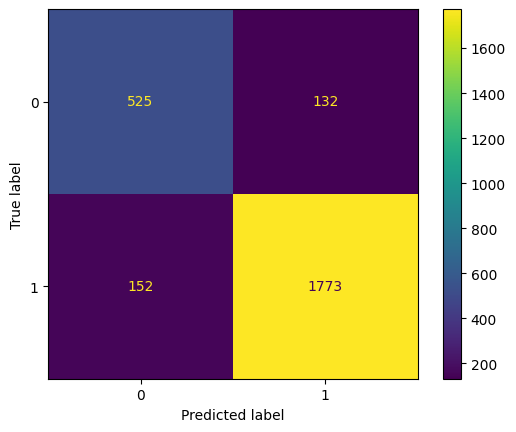

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm) 
disp.plot()